# Accuracy Comparison - Double-issue

In [206]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import collections  as mc
import statistics
import Trace
import scipy

# Local packages
from simulate import *

In [22]:
# Load data. Less than 2 MiB.
# Data aggregated over 5 runs, up to 100ms of simulation
#with open('parrot-traces/polybench-mf-jun14-optimized/polybench-mf-jun14-optimized.pkl', 'rb') as file:
with open('/net/netscratch/plavin3/experiment-results/Jun-30-3/SimStats.pkl', 'rb') as file:
    mf = pickle.load(file)
#with open('parrot-traces/polybench-normal-jun14/polybench-normal-jun14.pkl', 'rb') as file:
with open('/net/netscratch/plavin3/experiment-results/Jun-29-6/SimStats.pkl', 'rb') as file:
    norm = pickle.load(file)

In [23]:
mf.st['2mm'].ipc[0]

1.602610203013051

In [24]:
y_norm_ipc  = [norm.st[n].ipc[0] for n in names]
y_mf_ipc    = [mf.st[n].ipc[0]   for n in names]
#y_mfn_ipc   = [mf_n.st[n].ipc[0]   for n in names]

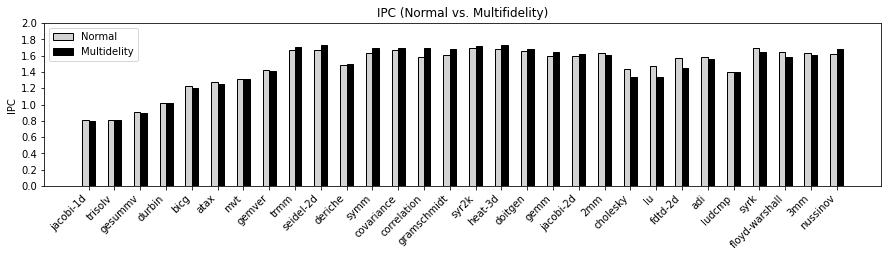

In [9]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-width/2, y_norm_ipc, width, color='lightgrey', label='Normal', edgecolor='black')
ax.bar(x+width/2, y_mf_ipc, width, color='black', label='Multidelity', edgecolor='black')
#ax.bar(x+width, y_mfn_ipc, width, color='lightblue', label='Multidelity New', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,2))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 11
ax.set_yticks([(2/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
fig.savefig('plots/ipc-normal-vs-mf.png')
#plt.tight_layout()

In [10]:
pct_err = []

def p_err(approx, exact):
    return (approx-exact)/exact * 100
def mape(arr):
    return np.mean(np.absolute(arr))

print('Percent error\n')
name_len = max([len(name) for name in names])
for (i, name) in enumerate(names):
    pe = p_err(y_mf_ipc[i], y_norm_ipc[i])
    pct_err.append(pe)
    print(f'{i}'.ljust(2), f'{name}'.ljust(name_len), f'{pe: 06.2f}%')
    
print(f'\nMAPE: {mape(pct_err):.2f}%')

Percent error

0  jacobi-1d      -02.00%
1  trisolv         00.39%
2  gesummv        -01.03%
3  durbin          00.08%
4  bicg           -02.34%
5  atax           -01.53%
6  mvt             00.31%
7  gemver         -01.20%
8  trmm            02.46%
9  seidel-2d       03.12%
10 deriche         00.34%
11 symm            04.07%
12 covariance      01.50%
13 correlation     06.51%
14 gramschmidt     05.03%
15 syr2k           00.93%
16 heat-3d         03.17%
17 doitgen         01.23%
18 gemm            02.70%
19 jacobi-2d       01.27%
20 2mm            -01.46%
21 cholesky       -06.05%
22 lu             -08.84%
23 fdtd-2d        -08.01%
24 adi            -01.80%
25 ludcmp          00.41%
26 syrk           -02.58%
27 floyd-warshall -03.75%
28 3mm            -01.41%
29 nussinov        03.48%

MAPE: 2.63%


In [91]:
# Speed up calculations
mf_times_seconds = []
norm_times_seconds = []
for name in names:
    mf_times_seconds.append(mf.st[name].times.real.mean/nu.s)
    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

speedup = [((norm_times_seconds[i] / mf_times_seconds[i])) for i in range(len(names))]

print('Speedup\n')
for i in range(len(names)):
    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup[i]: 7.2f}')

print(f'\nAverage speedup: {np.mean(speedup):.2f}')

Speedup

0  jacobi-1d         1.00
1  trisolv           1.00
2  gesummv           0.95
3  durbin            0.99
4  bicg              0.97
5  atax              0.97
6  mvt               1.00
7  gemver            0.96
8  trmm              2.49
9  seidel-2d         1.92
10 deriche           1.00
11 symm              2.30
12 covariance        2.45
13 correlation       2.35
14 gramschmidt       2.39
15 syr2k             2.05
16 heat-3d           1.29
17 doitgen           2.20
18 gemm              2.07
19 jacobi-2d         2.07
20 2mm               2.25
21 cholesky          1.03
22 lu                1.03
23 fdtd-2d           1.06
24 adi               1.01
25 ludcmp            0.96
26 syrk              0.99
27 floyd-warshall    1.21
28 3mm               0.97
29 nussinov          0.93

Average speedup: 1.46


In [46]:
# Calculate speedup of the Memory simulation (subtract off Ariel time)

def mean_ariel_time(data, name):
    return np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in data.st[name].profile])

mf_times_seconds_noariel = []
norm_times_seconds_noariel = []
for name in names:
    mf_times_seconds_noariel.append(mf.st[name].times.real.mean/nu.s - mean_ariel_time(mf,name))
    norm_times_seconds_noariel.append(norm.st[name].times.real.mean/nu.s - mean_ariel_time(norm,name))

In [14]:
ariel_time = np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile])
ariel_time

1082.829858

In [9]:
print('Percent speedup without Ariel')
#TODO - also remove parrot time from norm runs

speedup_pct = [((norm_times_seconds_noariel[i] / mf_times_seconds_noariel[i])-1)*100 for i in range(len(names))]

for i, n in enumerate(names):
    print(f'{n.ljust(14)}: {speedup_pct[i]:6.02f}%')

Percent speedup without Ariel
jacobi-1d     :  -9.61%
trisolv       :  -6.21%
gesummv       :  -9.76%
durbin        :  -9.36%
bicg          :  -4.81%
atax          :  -2.53%
mvt           :  -6.88%
gemver        :  -5.18%
heat-3d       :  86.44%
ludcmp        : 131.90%
syr2k         : 136.67%
trmm          : 157.45%
correlation   : 150.52%
gramschmidt   : 149.37%
symm          : 126.56%
covariance    : 121.50%
doitgen       : 109.49%
gemm          : 116.09%
jacobi-2d     : 118.08%
floyd-warshall: 103.76%
2mm           : 121.12%
cholesky      :   0.58%
seidel-2d     :   2.76%
deriche       :   2.22%
lu            :   2.21%
adi           :   1.93%
fdtd-2d       :   2.89%
syrk          :   1.65%
3mm           :   3.42%
nussinov      :   2.13%


In [301]:
#x = np.arange(len(names))
#width = 0.25
#fig, ax = plt.subplots()
#ax.bar(x-width/2, y_norm_ipc, width, color='lightgrey', label='Normal', edgecolor='black')
#ax.bar(x+width/2, y_mf_ipc, width, color='black', label='Multidelity', edgecolor='black')
##ax.bar(x+width, y_mfn_ipc, width, color='lightblue', label='Multidelity New', edgecolor='black')

#ax.set_xticks(x)
#ax.set_xticklabels(names, rotation=45, ha='right')
#ax.set_ylim((0,2))
#ax.set_ylabel('IPC', rotation=90)
#ax.set_title('IPC (Normal vs. Multifidelity)')
#ax.autoscale()
#plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
#nyticks = 11
#ax.set_yticks([(2/(nyticks-1))*x for x in np.arange(nyticks)])
#fig.set_size_inches((15,3))
#fig.savefig('plots/ipc-normal-vs-mf.png')
#plt.tight_layout()

def get_pickle(experiment):
    return f'/net/netscratch/plavin3/experiment-results/{experiment}/SimStats.pkl'

def normalized_plot(mf_files, norm_files, y_max, issue_rate, filename, **kwargs):
    mf = []
    for file in mf_files:
        with open(file, 'rb') as file:
            mf.append(pickle.load(file))
    norm = []
    for file in norm_files:
        with open(file, 'rb') as file:
            norm.append(pickle.load(file))
            
    names = sorted(list(mf[0].st.keys()))
    if 'matmul' in kwargs:
        names = sorted(list(mf[0].st.keys()), key=lambda n: int(n.split('-')[1]))
        name_labels = [int(n.split('-')[1]) for n in names]
    
    
    y_mf_ipc = []
    y_norm_ipc = []
    for data in mf:
        y_mf_ipc.append([data.st[n].ipc[0]   for n in names])
    for data in norm:
        y_norm_ipc.append([data.st[n].ipc[0] for n in names])

    y_mf_ipc_max = []
    y_norm_ipc_max = []
    y_mf_ipc_min = []
    y_norm_ipc_min = []
    y_mf_ipc_mean = []
    y_norm_ipc_mean = []
    for j in range(len(names)):
        y_mf_ipc_max.append(max([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_mf_ipc_min.append(min([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_mf_ipc_mean.append(np.mean([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_norm_ipc_max.append(max([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_min.append(min([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_mean.append(np.mean([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
    
    
    x = np.arange(len(names))
    width = 0.25
    fig, ax = plt.subplots()
    ax.bar(x-width/2, y_norm_ipc_mean, width, color='white', label='Normal', edgecolor='black')
    ax.bar(x+width/2, y_mf_ipc_mean, width, color='darkgrey', label='Multidelity', edgecolor='black')
        
    # Multifidelity Lines
    mf_max_lines = [[(i,y_mf_ipc_max[i]),(i+width,y_mf_ipc_max[i])] for i in range(len(names))]
    mf_min_lines = [[(i,y_mf_ipc_min[i]),(i+width,y_mf_ipc_min[i])] for i in range(len(names))]
    
    max_lc = mc.LineCollection(mf_max_lines, color='red', linewidths=1)
    min_lc = mc.LineCollection(mf_min_lines, color='red', linewidths=1)
    ax.add_collection(max_lc)
    ax.add_collection(min_lc)
    
    # Normal lines
    norm_max_lines = [[(i-width,y_norm_ipc_max[i]),(i,y_norm_ipc_max[i])] for i in range(len(names))]
    norm_min_lines = [[(i-width,y_norm_ipc_min[i]),(i,y_norm_ipc_min[i])] for i in range(len(names))]
    
    max_lc = mc.LineCollection(norm_max_lines, color='red', linewidths=1)
    min_lc = mc.LineCollection(norm_min_lines, color='red', linewidths=1)
    ax.add_collection(max_lc)
    ax.add_collection(min_lc)

    ax.set_xticks(x)
    if 'matmul' in kwargs:
        ax.set_xticklabels(name_labels)
        ax.set_xlabel('Block size')
    else:
        ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylim((0,y_max))
    ax.set_ylabel('IPC', rotation=90)
    ax.set_title(f'IPC (issue rate = {issue_rate})')
    ax.autoscale()
    matplotlib.rcParams["legend.loc"] = 'upper left'
    plt.legend()
    
    #print('y_mf_ipc_mean', y_mf_ipc_mean)
    #print('y_norm_ipc_mean', y_norm_ipc_mean)
    ape = [100*np.abs((actual-expected)/expected) for (actual, expected) in zip(y_mf_ipc_mean, y_norm_ipc_mean)]
    #print(ape)
    print(f'MAPE of mean ipc: {np.mean(ape)}')
    
    
    plt.tight_layout()
    

    #ax.yaxis.set_label_coords(-.07, 0.96)
    nyticks = 11
    ax.set_yticks([(y_max/(nyticks-1))*x for x in np.arange(nyticks)])
    fig.set_size_inches((12,3))
    plt.tight_layout()
    if filename is not None:
        fig.savefig(filename)
        
    return ape
    #fig.savefig('plots/ipc-normal-vs-mf.png')
    #plt.tight_layout()

MAPE of mean ipc: 1.979648997910796
MAPE of mean ipc: 4.67073645750958
MAPE of mean ipc: 10.334939200731265


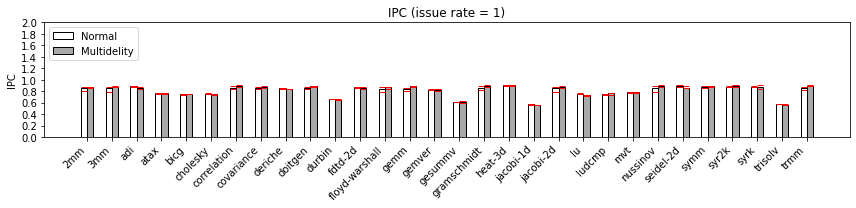

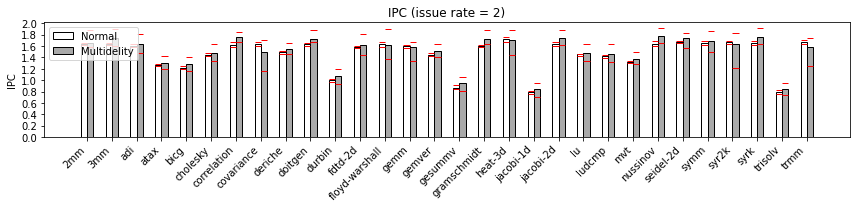

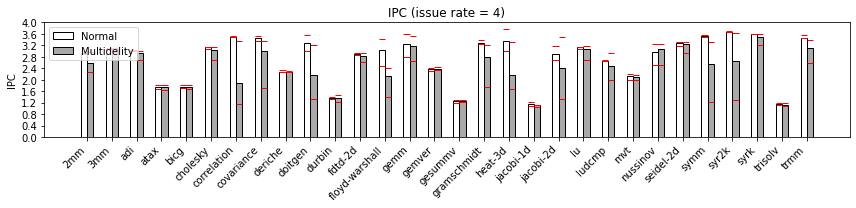

In [307]:
mf_1disp = [get_pickle(experiment) for experiment in ['Jun-29-0','Jun-29-1','Jun-29-2','Jun-29-3','Jun-29-4']]
norm_1disp = [get_pickle(experiment) for experiment in ['Jun-27-0','Jun-27-1','Jun-27-2','Jun-27-3','Jun-27-4']]

mf_2disp = [get_pickle(experiment) for experiment in ['Jun-30-3','Jun-30-4','Jun-30-5','Jun-30-6','Jun-30-7']]
norm_2disp = [get_pickle(experiment) for experiment in ['Jun-29-5','Jun-29-6','Jun-30-0','Jun-30-1','Jun-30-2']]

mf_4disp = [get_pickle(experiment) for experiment in ['Jul-04-1', 'Jul-04-0', 'Jul-03-5', 'Jul-03-4', 'Jul-03-3']]
norm_4disp = [get_pickle(experiment) for experiment in ['Jul-03-2', 'Jul-03-1', 'Jul-03-0', 'Jul-02-1', 'Jul-02-0']]

norm_spec = [get_pickle(experiment) for experiment in ['Jul-06-0', 'Jul-06-1', 'Jul-06-2', 'Jul-06-3', 'Jul-06-4']]
mf_spec = [get_pickle(experiment) for experiment in ['Jul-06-5', 'Jul-06-6', 'Jul-06-7', 'Jul-06-8', 'Jul-06-9']]

_ = normalized_plot(mf_1disp, norm_1disp, y_max=2, issue_rate=1, filename='plots/accuracy-issue-rate-1.pdf')
_ = normalized_plot(mf_2disp, norm_2disp, y_max=2, issue_rate=2, filename='plots/accuracy-issue-rate-2.pdf')
_ = normalized_plot(mf_4disp, norm_4disp, y_max=4, issue_rate=4, filename='plots/accuracy-issue-rate-4.pdf')
#normalized_plot(mf_spec, norm_spec, y_max=2, issue_rate=1, filename=None)
 

MAPE of mean ipc: 1.979648997910796
printing table...
vvvvvvvv

\begin{table}[H]
\centering
\begin{tabular}{lllrr}
\toprule
      Benchmark & IPC$_{\text{true}}$ &  IPC$_{\text{mf}}$  & Pct. Error & Speedup \\
\midrule
      2mm & $0.86\pm0.03$ & $0.87\pm0.03$ & -1.04 & 2.18 \\
      3mm & $0.85\pm0.03$ & $0.88\pm0.03$ & -2.91 & \color{red}0.96\color{black} \\
      adi & $0.88\pm0.01$ & $0.86\pm0.01$ & 2.27 & \color{red}0.99\color{black} \\
      atax & $0.76\pm0.01$ & $0.76\pm0.01$ & -0.11 & \color{red}0.97\color{black} \\
      bicg & $0.75\pm0.01$ & $0.75\pm0.01$ & -0.22 & \color{red}0.98\color{black} \\
      cholesky & $0.76\pm0.01$ & $0.75\pm0.01$ & 0.75 & \color{red}1.00\color{black} \\
      correlation & $0.86\pm0.02$ & $0.90\pm0.02$ & -3.60 & 2.33 \\
      covariance & $0.86\pm0.01$ & $0.88\pm0.01$ & -1.73 & 1.99 \\
      deriche & $0.85\pm0.01$ & $0.84\pm0.01$ & 1.81 & \color{red}1.01\color{black} \\
      doitgen & $0.86\pm0.02$ & $0.88\pm0.02$ & -2.32 & 1.99 \\
      durb

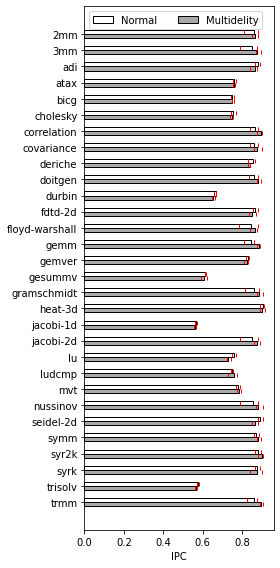

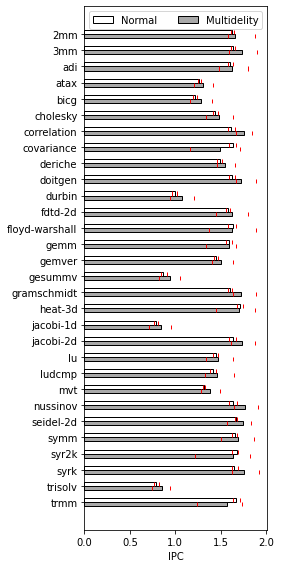

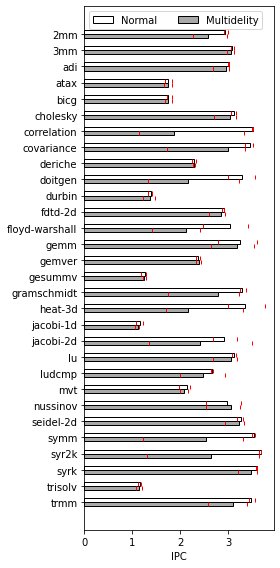

In [375]:
def normalized_plot_horizontal(mf_files, norm_files, y_max, issue_rate, filename, **kwargs):
    mf = []
    for file in mf_files:
        with open(file, 'rb') as file:
            mf.append(pickle.load(file))
    norm = []
    for file in norm_files:
        with open(file, 'rb') as file:
            norm.append(pickle.load(file))
            
    names = sorted(list(mf[0].st.keys()))
    if 'matmul' in kwargs:
        names = sorted(list(mf[0].st.keys()), key=lambda n: int(n.split('-')[1]))
        name_labels = [int(n.split('-')[1]) for n in names]
    
    
    y_mf_ipc = []
    y_norm_ipc = []
    for data in mf:
        y_mf_ipc.append([data.st[n].ipc[0]   for n in names])
    for data in norm:
        y_norm_ipc.append([data.st[n].ipc[0] for n in names])

    y_mf_ipc_max = []
    y_norm_ipc_max = []
    y_mf_ipc_min = []
    y_norm_ipc_min = []
    y_mf_ipc_mean = []
    y_norm_ipc_mean = []
    y_mf_ipc_sd = []
    y_norm_ipc_sd = []
    for j in range(len(names)):
        y_mf_ipc_max.append(max([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_mf_ipc_min.append(min([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_mf_ipc_mean.append(np.mean([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_norm_ipc_max.append(max([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_min.append(min([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_mean.append(np.mean([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_sd.append(np.std([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_mf_ipc_sd.append(np.std([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        
        
    ###########################
    # Copied from speedup
    ###########################
    y_mf_speedup = []
    y_norm_speedup = []
    for data in mf:
        y_mf_speedup.append([data.st[n].times.real.mean/nu.s for n in names])
    for data in norm:
        y_norm_speedup.append([data.st[n].times.real.mean/nu.s for n in names])

    y_mf_speedup_max = []
    y_norm_speedup_max = []
    y_mf_speedup_min = []
    y_norm_speedup_min = []
    y_mf_speedup_mean = []
    y_norm_speedup_mean = []
    for j in range(len(names)):
        y_mf_speedup_max.append(max([y_mf_speedup[i][j] for i in range(len(y_mf_speedup))]))
        y_mf_speedup_min.append(min([y_mf_speedup[i][j] for i in range(len(y_mf_speedup))]))
        y_mf_speedup_mean.append(np.mean([y_mf_speedup[i][j] for i in range(len(y_mf_speedup))]))
        y_norm_speedup_max.append(max([y_norm_speedup[i][j] for i in range(len(y_norm_speedup))]))
        y_norm_speedup_min.append(min([y_norm_speedup[i][j] for i in range(len(y_norm_speedup))]))
        y_norm_speedup_mean.append(np.mean([y_norm_speedup[i][j] for i in range(len(y_norm_speedup))]))
    speedup = [y_norm_speedup_mean[i]/y_mf_speedup_mean[i] for i in range(len(names))]    
    ############################
        
    x = np.arange(len(names))
    width = 0.25
    fig, ax = plt.subplots()
    ax.barh(x-width/2, y_norm_ipc_mean, width, color='white', label='Normal', edgecolor='black')
    ax.barh(x+width/2, y_mf_ipc_mean, width, color='darkgrey', label='Multidelity', edgecolor='black')
            
    # Multifidelity Lines
    mf_max_lines = [[(y_mf_ipc_max[i],i),(y_mf_ipc_max[i],i+width)] for i in range(len(names))]
    mf_min_lines = [[(y_mf_ipc_min[i],i),(y_mf_ipc_min[i],i+width)] for i in range(len(names))]
    
    max_lc = mc.LineCollection(mf_max_lines, color='red', linewidths=1)
    min_lc = mc.LineCollection(mf_min_lines, color='red', linewidths=1)
    ax.add_collection(max_lc)
    ax.add_collection(min_lc)
    
    # Normal lines
    norm_max_lines = [[(y_norm_ipc_max[i], i-width),(y_norm_ipc_max[i], i)] for i in range(len(names))]
    norm_min_lines = [[(y_norm_ipc_min[i], i-width),(y_norm_ipc_min[i], i)] for i in range(len(names))]
    
    max_lc = mc.LineCollection(norm_max_lines, color='red', linewidths=1)
    min_lc = mc.LineCollection(norm_min_lines, color='red', linewidths=1)
    ax.add_collection(max_lc)
    ax.add_collection(min_lc)

    #ax.set_xticks(x)
    if 'matmul' in kwargs:
        ax.set_xticklabels(name_labels)
        ax.set_xlabel('Block size')
    else:
        ax.set_yticks([*range(30)])
        ax.set_yticklabels(names, ha='right')
        pass
    #ax.set_ylim((0,y_max))
    ax.set_xlabel('IPC')
    #ax.set_title(f'IPC (issue rate = {issue_rate})')
    ax.autoscale()
    #matplotlib.rcParams["legend.loc"] = 'upper left'
    plt.legend(ncol=2)
    
    #print('y_mf_ipc_mean', y_mf_ipc_mean)
    #print('y_norm_ipc_mean', y_norm_ipc_mean)
    ape = [100*np.abs((actual-expected)/expected) for (actual, expected) in zip(y_mf_ipc_mean, y_norm_ipc_mean)]
    #print(ape)
    print(f'MAPE of mean ipc: {np.mean(ape)}')
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    

    #ax.yaxis.set_label_coords(-.07, 0.96)
    #nyticks = 11
    #ax.set_yticks([(y_max/(nyticks-1))*x for x in np.arange(nyticks)])
    fig.set_size_inches((4,8))
    plt.tight_layout()
    if filename is not None:
        fig.savefig(filename)
        
    if 'tableName' in kwargs:
        print('printing table...\nvvvvvvvv\n')
        print(r'\begin{table}[H]')
        print(r'\centering')
        print(r'\begin{tabular}{lllrr}')
        print(r'\toprule')
        print(r'      Benchmark & IPC$_{\text{true}}$ &  IPC$_{\text{mf}}$  & Pct. Error & Speedup \\')
        print(r'\midrule')
        er = []
        for i, n in enumerate(names):
            error = 100*(y_norm_ipc_mean[i] - y_mf_ipc_mean[i])/y_mf_ipc_mean[i]
            er.append(np.abs(error))
            if speedup[i] < 1.05:
                print(f'      {n} & ${y_norm_ipc_mean[i]:.2f}\\pm{y_norm_ipc_sd[i]:.2f}$ & ${y_mf_ipc_mean[i]:.2f}\\pm{y_mf_ipc_sd[i]:.2f}$ & {error:.2f} & \\color{{red}}{speedup[i]:.2f}\\color{{black}} \\\\')
            else:
                print(f'      {n} & ${y_norm_ipc_mean[i]:.2f}\\pm{y_norm_ipc_sd[i]:.2f}$ & ${y_mf_ipc_mean[i]:.2f}\\pm{y_mf_ipc_sd[i]:.2f}$ & {error:.2f} & {speedup[i]:.2f} \\\\') 
        print(r'\midrule')
        print(f'      Mean & &  & {np.mean(er):.2f} & {np.mean(speedup):.2f} \\\\')
        print(r'\bottomrule')
        print(r'\end{tabular}')
        print(r'\caption{\todo{caption}}')
        print(f'\\label{{tab:{kwargs["tableName"]}}}')
        print(r'\end{table}')
        print('\n^^^^^^^\ndone.')
        
    return ape
    #fig.savefig('plots/ipc-normal-vs-mf.png')
    #plt.tight_layout()
    
_ = normalized_plot_horizontal(mf_1disp, norm_1disp, y_max=2, issue_rate=1, filename='plots/accuracy-issue-rate-1-horizontal.pdf', tableName='issuerate1')
_ = normalized_plot_horizontal(mf_2disp, norm_2disp, y_max=2, issue_rate=2, filename='plots/accuracy-issue-rate-2-horizontal.pdf', tableName='issuerate2')
_ = normalized_plot_horizontal(mf_4disp, norm_4disp, y_max=4, issue_rate=4, filename='plots/accuracy-issue-rate-4-horizontal.pdf')

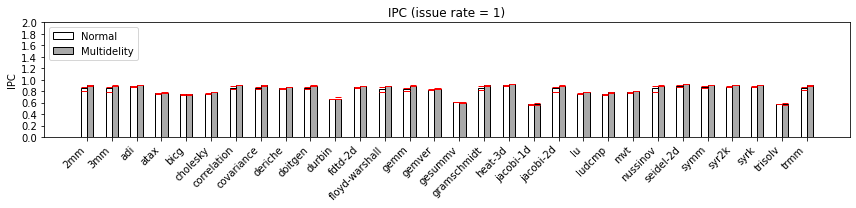

In [158]:
norm_1kib = [get_pickle(experiment) for experiment in ['Jul-10-0','Jul-10-1','Jul-11-0','Jul-11-1']]
norm_2kib = [get_pickle(experiment) for experiment in ['Jul-11-3','Jul-11-4','Jul-11-5','Jul-11-6', 'Jul-11-7']]

normalized_plot(norm_2kib, norm_1disp, y_max=2, issue_rate=1, filename=None)

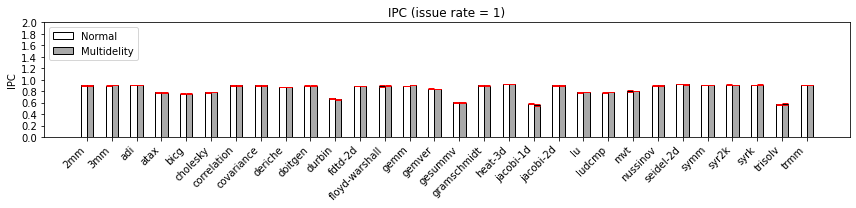

In [164]:
norm_8kib = [get_pickle(experiment) for experiment in ['Jul-11-20','Jul-11-21','Jul-11-22']]
norm_16kib = [get_pickle(experiment) for experiment in ['Jul-12-0','Jul-12-1','Jul-12-2']]
norm_32kib = [get_pickle(experiment) for experiment in ['Jul-12-3','Jul-12-4','Jul-12-5']]
#normalized_plot(norm_8kib, norm_1disp, y_max=2, issue_rate=1, filename=None)
#normalized_plot(norm_16kib, norm_1disp, y_max=2, issue_rate=1, filename=None)
normalized_plot(norm_32kib, norm_1kib, y_max=2, issue_rate=1, filename=None)

In [154]:
_1kib = []
for filename in norm_1kib:
    with open(filename, 'rb') as file:
        _1kib.append(pickle.load(file))
print(sorted(_1kib[4].st.keys()))

#data.st[n].ipc[0]

['2mm', '3mm', 'adi', 'atax', 'bicg', 'cholesky', 'covariance', 'deriche', 'doitgen', 'durbin', 'fdtd-2d', 'floyd-warshall', 'gemm', 'gemver', 'gesummv', 'gramschmidt', 'heat-3d', 'jacobi-1d', 'jacobi-2d', 'lu', 'ludcmp', 'mvt', 'nussinov', 'seidel-2d', 'symm', 'syr2k', 'syrk', 'trisolv', 'trmm']


Mean speedup: 1.458717139013117
Mean speedup: 1.474007437904757
Mean speedup: 1.384735631848555


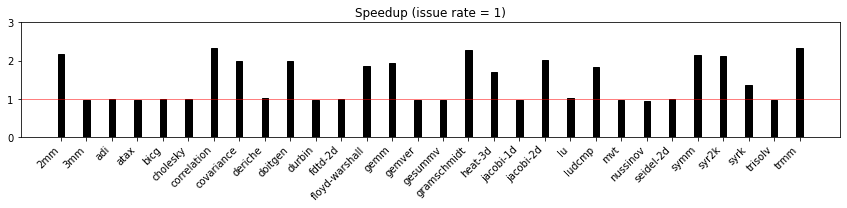

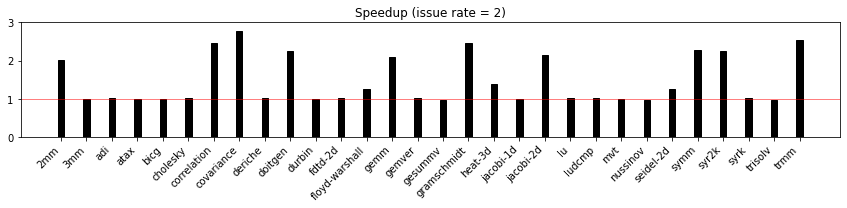

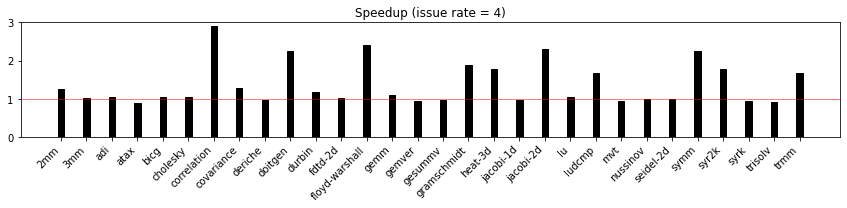

In [295]:
# Speed up calculations

def speedup_plot(mf_files, norm_files, y_max, issue_rate, filename, **kwargs):
    mf = []
    for file in mf_files:
        with open(file, 'rb') as file:
            mf.append(pickle.load(file))
    norm = []
    for file in norm_files:
        with open(file, 'rb') as file:
            norm.append(pickle.load(file))
            
    names = sorted(list(mf[0].st.keys()))
    
    if 'matmul' in kwargs:
        names = sorted(list(mf[0].st.keys()), key=lambda n: int(n.split('-')[1]))
        name_labels = [int(n.split('-')[1]) for n in names]
    
    
    y_mf_ipc = []
    y_norm_ipc = []
    for data in mf:
        y_mf_ipc.append([data.st[n].times.real.mean/nu.s for n in names])
    for data in norm:
        y_norm_ipc.append([data.st[n].times.real.mean/nu.s for n in names])

    y_mf_ipc_max = []
    y_norm_ipc_max = []
    y_mf_ipc_min = []
    y_norm_ipc_min = []
    y_mf_ipc_mean = []
    y_norm_ipc_mean = []
    for j in range(len(names)):
        y_mf_ipc_max.append(max([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_mf_ipc_min.append(min([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_mf_ipc_mean.append(np.mean([y_mf_ipc[i][j] for i in range(len(y_mf_ipc))]))
        y_norm_ipc_max.append(max([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_min.append(min([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
        y_norm_ipc_mean.append(np.mean([y_norm_ipc[i][j] for i in range(len(y_norm_ipc))]))
    
    
    speedup = [y_norm_ipc_mean[i]/y_mf_ipc_mean[i] for i in range(len(names))]
    
    x = np.arange(len(names))
    width = 0.25
    fig, ax = plt.subplots()
    ax.bar(x, speedup, width, color='black', label='Speedup', edgecolor='black')
    #ax.bar(x+width/2, y_mf_ipc_mean, width, color='darkgrey', label='Multidelity', edgecolor='black')

    ax.set_xticks(x)
    if 'matmul' in kwargs:
        ax.set_xticklabels(name_labels)
        ax.set_xlabel('Block size')
    else:
        ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylim((0,3))
    #ax.set_ylabel('IPC', rotation=90)
    ax.set_title(f'Speedup (issue rate = {issue_rate})')
    #ax.autoscale()
    matplotlib.rcParams["legend.loc"] = 'upper left'
    ax.axhline(1, linewidth=0.5, color='red')
    #plt.legend()

    ##ax.yaxis.set_label_coords(-.07, 0.96)
    #nyticks = 11
    #ax.set_yticks([(y_max/(nyticks-1))*x for x in np.arange(nyticks)])
    fig.set_size_inches((12,3))
    plt.tight_layout()
    #plt.show()
    if filename is not None:
        fig.savefig(filename)
    ##plt.tight_layout()
    
    print(f'Mean speedup: {np.mean(speedup)}')

# Speed up calculations
#mf_times_seconds = []
#norm_times_seconds = []
#for name in names:
#    mf_times_seconds.append(mf.st[name].times.real.mean/nu.s)
#    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

#speedup = [((norm_times_seconds[i] / mf_times_seconds[i])) for i in range(len(names))]

#print('Speedup\n')
#for i in range(len(names)):
#    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup[i]: 7.2f}')

#print(f'\nAverage speedup: {np.mean(speedup):.2f}')

speedup_plot(mf_1disp, norm_1disp, y_max=2, issue_rate=1, filename='plots/speedup-issue-rate-1.pdf')
speedup_plot(mf_2disp, norm_2disp, y_max=2, issue_rate=2, filename='plots/speedup-issue-rate-2.pdf')
speedup_plot(mf_4disp, norm_4disp, y_max=4, issue_rate=4, filename='plots/speedup-issue-rate-4.pdf')
#speedup_plot(mf_spec, norm_spec, y_max=2, issue_rate=1, filename=None)

Mean speedup: 1.5914231848981573


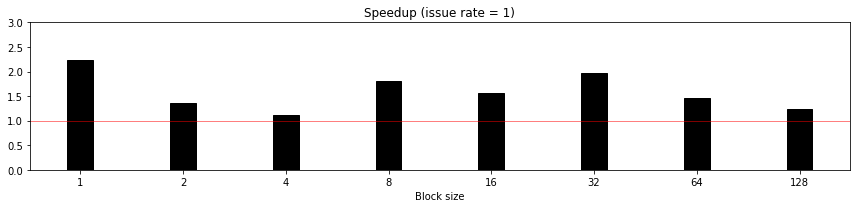

In [400]:
#norm_2th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-0', 'Jul-17-1', 'Jul-17-2']]
#mf_2th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-3', 'Jul-17-4', 'Jul-17-5']]


norm_2th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-0', 'Jul-17-1', 'Jul-17-2']]
mf_2th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-3', 'Jul-17-4', 'Jul-17-5']]
speedup_plot(mf_2th_4kib, norm_2th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)

Mean speedup: 1.1194915940095107


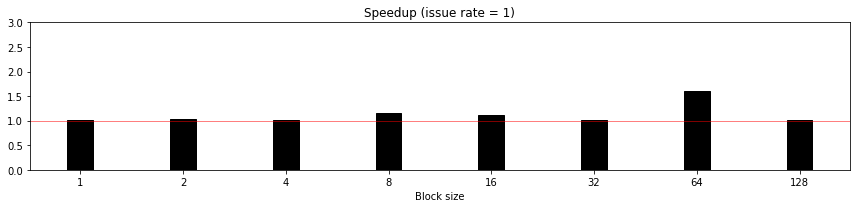

In [401]:
#norm_8th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-12', 'Jul-17-13', 'Jul-17-14']]
#mf_8th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-15']]# 'Jul-17-16', 'Jul-17-17']]
norm_8th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-12', 'Jul-17-13', 'Jul-17-14']]
mf_8th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-15']]
speedup_plot(mf_8th_4kib, norm_8th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)

In [197]:
[np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile]

[477.159364, 478.199233, 472.19425700000005, 458.189289, 468.041158]

MAPE of mean ipc: 11.096714498075869
MAPE of mean ipc: 10.269838120392812
MAPE of mean ipc: 6.52231100264101


[9.731337379718997,
 1.3956228184546065,
 10.630536262569285,
 3.076054668005702,
 3.0129997370999306,
 5.5464986937709275,
 12.913773657021673,
 5.871664804486958]

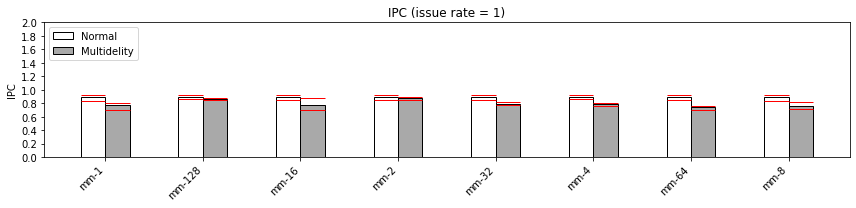

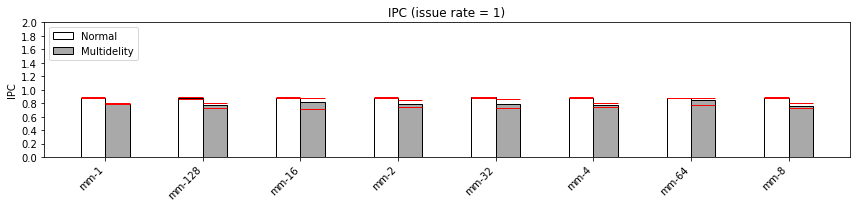

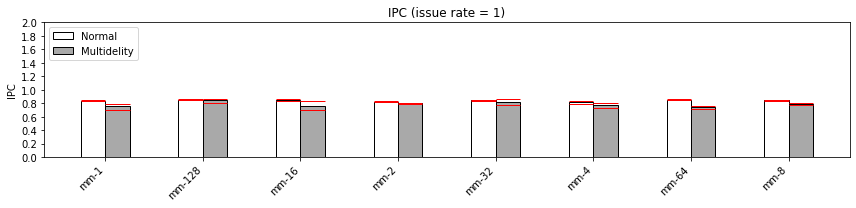

In [408]:
# Cache size
norm_1th_2kib = [get_pickle(experiment) for experiment in ['Jul-16-3', 'Jul-16-4', 'Jul-16-5']]
mf_1th_2kib   = [get_pickle(experiment) for experiment in ['Jul-16-6', 'Jul-16-7', 'Jul-16-8']]
norm_1th_4kib = [get_pickle(experiment) for experiment in ['Jul-16-9', 'Jul-16-10', 'Jul-16-11']]
mf_1th_4kib   = [get_pickle(experiment) for experiment in ['Jul-16-12', 'Jul-16-13', 'Jul-16-14']]
norm_1th_8kib = [get_pickle(experiment) for experiment in ['Jul-16-15', 'Jul-16-16', 'Jul-16-17']]
mf_1th_8kib   = [get_pickle(experiment) for experiment in ['Jul-16-18', 'Jul-16-19', 'Jul-16-20']]

# Multi-threaded
norm_2th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-0', 'Jul-17-1', 'Jul-17-2']]
mf_2th_4kib   = [get_pickle(experiment) for experiment in ['Jul-17-3', 'Jul-17-4', 'Jul-17-5']]
norm_4th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-6', 'Jul-17-7', 'Jul-17-8']]
mf_4th_4kib   = [get_pickle(experiment) for experiment in ['Jul-17-9', 'Jul-17-10', 'Jul-17-11']]
norm_8th_4kib = [get_pickle(experiment) for experiment in ['Jul-17-12', 'Jul-17-13', 'Jul-17-14']]
mf_8th_4kib   = [get_pickle(experiment) for experiment in ['Jul-17-15']]# 'Jul-17-16', 'Jul-17-17']]

#speedup_plot(mf_1th_2kib, norm_1th_2kib, y_max=2, issue_rate=1, filename=None, matmul=True)
normalized_plot(mf_1th_2kib, norm_1th_2kib, y_max=2, issue_rate=1, filename=None)

#speedup_plot(mf_1th_4kib, norm_1th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)
normalized_plot(mf_1th_4kib, norm_1th_4kib, y_max=2, issue_rate=1, filename=None)

#speedup_plot(mf_1th_8kib, norm_1th_8kib, y_max=2, issue_rate=1, filename=None, matmul=True)
normalized_plot(mf_1th_8kib, norm_1th_8kib, y_max=2, issue_rate=1, filename=None)

#speedup_plot(mf_2th_4kib, norm_2th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)
#normalized_plot(mf_2th_4kib, norm_2th_4kib, y_max=2, issue_rate=1, filename=None)

#speedup_plot(mf_4th_4kib, norm_4th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)
#normalized_plot(mf_4th_4kib, norm_4th_4kib, y_max=2, issue_rate=1, filename=None)

#speedup_plot(mf_8th_4kib, norm_8th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)
#normalized_plot(mf_8th_4kib, norm_8th_4kib, y_max=2, issue_rate=1, filename=None)

In [416]:
#speedup_plot(mf_8th_4kib, norm_8th_4kib, y_max=2, issue_rate=1, filename=None, matmul=True)
#normalized_plot(mf_8th_4kib, norm_8th_4kib, y_max=2, issue_rate=1, filename=None)

mf_8th_4kib
with open(mf_8th_4kib[0], 'rb') as file:
    mf = pickle.load(file)
    print(mf.st)

{'mm-64': Profiler: ClockStats
                         Name     count   handler time (s)  \
0                 ariel.ariel  49999999            566.077   
1            memHierarchy.Bus   6753959              9.616   
2          memHierarchy.Cache  34689275            274.755   
3  memHierarchy.MemController  12499999             30.960   
4         memHierarchy.Parrot  42867466             95.555   

    avg. handler time (ns)  
0                    11321  
1                     1423  
2                     7920  
3                     2476  
4                     2229  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      1539498           0.417                   270
1  memHierarchy.MemLink     58303095         361.471                  6199
2   memHierarchy.Parrot     86886007         100.801                  1160
Simulated time:
  25.00 (+/-0.00) ms (sem 0.00)
Wallclock Time:
  Real: 1476760.00 (+/-0.00) ms (sem 

Mean speedup: 2.0928138907317066
MAPE of mean ipc: 0.6490561186540665


[0.6440797698238058,
 0.05679793092141811,
 0.32666141083629535,
 0.7721825727512611,
 0.390006865454934,
 0.16840338185097986,
 1.1984598025778452,
 1.051018445337848,
 1.2350221615112116,
 0.3181069716485649,
 1.7166920967961872,
 1.2054543487072817,
 0.6159352874216564,
 0.622734915652499,
 0.11900686649744348,
 0.3009857840891623,
 0.2924054052407371]

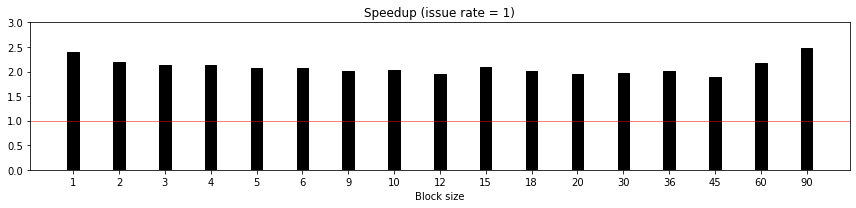

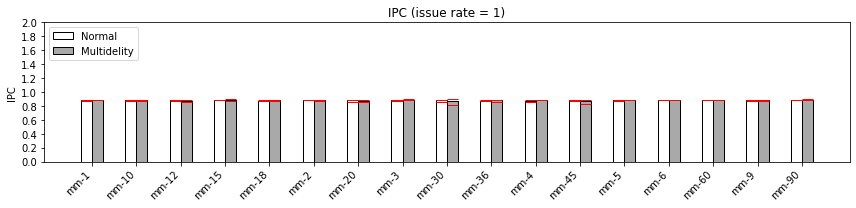

In [409]:
norm180 = [get_pickle(experiment) for experiment in['Jul-15-0', 'Jul-15-1', 'Jul-15-2', 'Jul-15-3', 'Jul-15-4']]
mf180 = [get_pickle(experiment) for experiment in['Jul-15-5', 'Jul-15-6', 'Jul-15-7', 'Jul-15-8', 'Jul-15-9']]

speedup_plot(mf180, norm180, y_max=2, issue_rate=1, filename=None, matmul=True)
normalized_plot(mf180, norm180, y_max=2, issue_rate=1, filename=None)

In [395]:
print('Parrot time')
clock=norm.st['2mm'].profile[0]['ClockStats']
list(clock[clock['Name']=='memHierarchy.Parrot'][' handler time (s)'])

Parrot time


[465.710888]

In [274]:
mf.st['2mm']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999           1175.339   
1            memHierarchy.Bus    8446518             13.142   
2          memHierarchy.Cache   39507364            308.108   
3  memHierarchy.MemController   49999999            121.382   
4         memHierarchy.Parrot  145400710            315.106   

    avg. handler time (ns)  
0                     5876  
1                     1555  
2                     7798  
3                     2427  
4                     2167  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      2162912           0.579                   267
1  memHierarchy.MemLink    108949898         651.677                  5981
2   memHierarchy.Parrot    187950003         257.391                  1369
Simulated time:
  23067.82 (+/-0.00) ms
Wallclock Time:
  Real: 676904356.15 (+/-0.00) ms
  User: 6671120

In [174]:
mf_1disp_ex = ['Jun-29-0','Jun-29-1','Jun-29-2','Jun-29-3','Jun-29-4']
#mf_1disp = [get_pickle(experiment) for experiment in mf_1disp_ex]
trace_dirs = [f'./experiment-results/{x}/trace' for x in mf_1disp_ex]

tt = Trace.TraceList(trace_dirs[0], new_ext=True)
tt.load()



In [240]:
def has_mf(stable):
    return np.any([ss>0 for ss in stable['stable_size']])

def get_rr(t):
    if not has_mf(t.stable):
        return None
    phases = [p for p in t.stable['phase']]
    rr = {}
    for p in phases:
        start = list(t.stable[t.stable['phase']==p]['stable_start'])[0]
        size = list(t.stable[t.stable['phase']==p]['stable_size'])[0]
        end = start + size
        if size == 0:
            continue
        rr[p] = np.array(t.data['latency_nano'][start:end])
    return rr

straps = 100
def bootstrap_mean(rr):
    if rr is None:
        return None
    ret = {}
    for phase in rr:
        means = []
        for i in range(straps):
            means.append(np.mean(np.random.choice(rr[phase], len(rr[phase]))))
        ret[phase] = np.std(means)
    return ret
rr = get_rr(tt[0])
bootstrap_mean(rr)


{0: 0.03606114786492047}

In [241]:
longest = max([len(t.name) for t in tt])
for t in tt:
    rr = get_rr(t)
    bm = bootstrap_mean(rr)
    print(t.name.ljust(longest), bm)
    
    
# todo, compare sem with actual error ? 
# look at disp = 2 plots

2mm            {0: 0.04133688456780498}
3mm            None
adi            None
atax           None
bicg           None
cholesky       None
correlation    {1: 0.03143110888936905}
covariance     {1: 0.04955738595206589}
deriche        {0: 0.0821666990033618}
doitgen        {0: 0.024505848909065923}
durbin         None
fdtd-2d        None
floyd-warshall {0: 0.00905109514623444}
gemm           {0: 0.011073437786404523}
gemver         None
gesummv        None
gramschmidt    {0: 0.03875752175971431}
heat-3d        {1: 0.054674668332805154}
jacobi-1d      None
jacobi-2d      {0: 0.01916364221319039}
lu             None
ludcmp         {0: 0.02724879578055543}
mvt            None
nussinov       None
seidel-2d      None
symm           {0: 0.027831422988943737}
syr2k          {1: 0.027707740324446357}
syrk           {0: 0.020757530727208963}
trisolv        None
trmm           {0: 0.03876778625702193}


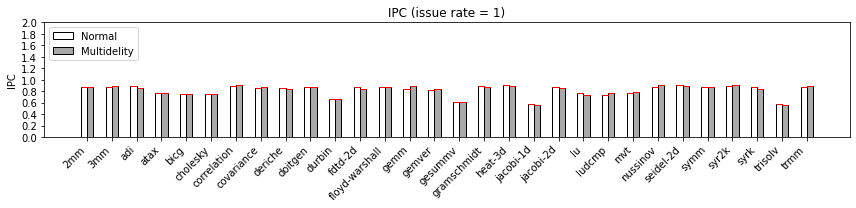

In [245]:
ape = normalized_plot([mf_1disp[0]], [norm_1disp[0]], y_max=2, issue_rate=1, filename='plots/accuracy-issue-rate-1.pdf')


[0.4488733566401195,
 1.9719473947178272,
 3.330271767692114,
 0.38856891288798645,
 1.0296885697748097,
 0.42359414812414764,
 2.375328448256014,
 1.80624095967273,
 3.787076825704537,
 0.19165874923316092,
 0.005417994749077663,
 3.695010987751257,
 0.09338186655585137,
 5.44914530126929,
 1.0485283774239975,
 1.0080549657684508,
 0.5965891832485554,
 1.8514231220977797,
 1.5831241762522992,
 2.172090865248578,
 5.018512495169843,
 3.7980717797357,
 2.249426091710529,
 2.950220519959091,
 2.7565398758783433,
 0.7726863315467282,
 0.9742720856555614,
 4.672558761709996,
 1.89825219225241,
 2.601160676746333]

MAPE of mean ipc: 1.5025012243069766
MAPE of mean ipc: 8.122466691414708
MAPE of mean ipc: 1.5171159513118004
printing table...
vvvvvvvv

\begin{table}[H]
\centering
\begin{tabular}{lllrr}
\toprule
      Benchmark & IPC$_{\text{true}}$ &  IPC$_{\text{mf}}$  & Pct. Error & Speedup \\
\midrule
      2mm & $0.90\pm0.00$ & $0.88\pm0.00$ & 1.87 & 2.39 \\
      3mm & $0.89\pm0.00$ & $0.92\pm0.00$ & -3.33 & \color{red}0.97\color{black} \\
      adi & $0.90\pm0.00$ & $0.90\pm0.00$ & 0.19 & \color{red}1.01\color{black} \\
      atax & $0.68\pm0.01$ & $0.69\pm0.01$ & -1.43 & \color{red}0.97\color{black} \\
      bicg & $0.67\pm0.00$ & $0.68\pm0.00$ & -0.98 & \color{red}0.97\color{black} \\
      cholesky & $0.64\pm0.00$ & $0.63\pm0.00$ & 1.31 & \color{red}1.01\color{black} \\
      correlation & $0.89\pm0.01$ & $0.91\pm0.01$ & -2.36 & 2.37 \\
      covariance & $0.89\pm0.00$ & $0.90\pm0.00$ & -1.20 & 2.16 \\
      deriche & $0.87\pm0.00$ & $0.88\pm0.00$ & -0.94 & 1.43 \\
      doitgen & $0.89\pm

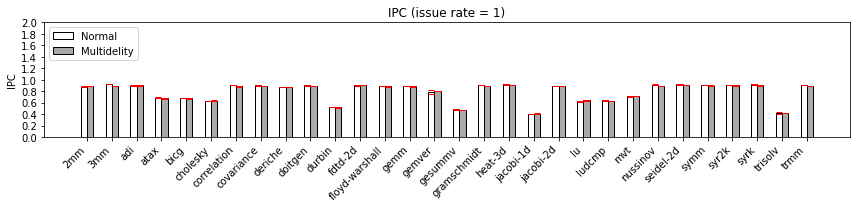

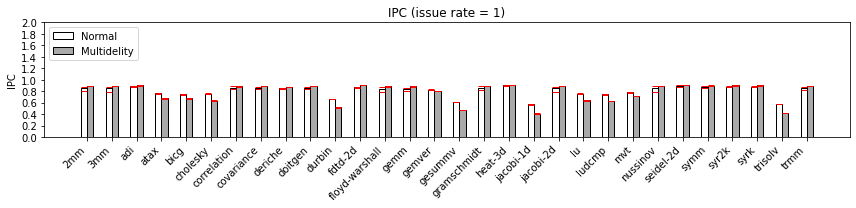

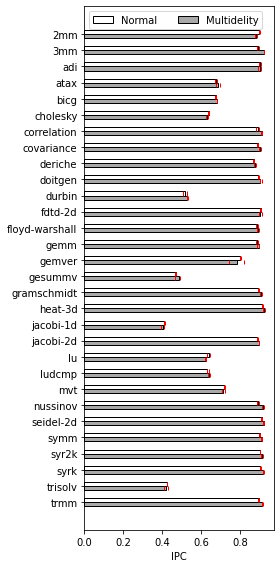

In [378]:
norm_timingdram = [get_pickle(experiment) for experiment in ['Jul-12-7','Jul-13-0','Jul-13-1']]
mf_timingdram   = [get_pickle(experiment) for experiment in ['Jul-13-2','Jul-13-3','Jul-13-4']]

_ = normalized_plot(norm_timingdram, mf_timingdram, y_max=2, issue_rate=1, filename='plots/accuracy-timingdram.pdf')
normalized_plot(norm_timingdram, norm_1disp, y_max=2, issue_rate=1, filename=None)

_ = normalized_plot_horizontal(mf_timingdram, norm_timingdram, y_max=2, issue_rate=1, filename='plots/accuracy-timingdram-horizontal.pdf', tableName='timingdram')


Mean speedup: 1.5885356471680834


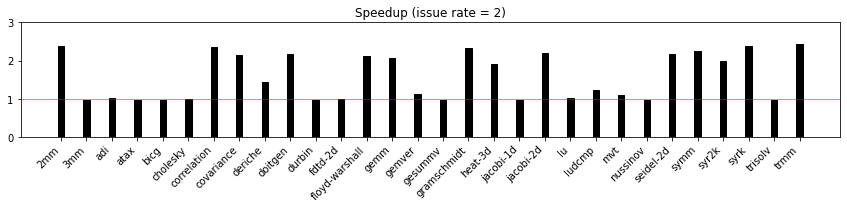

In [377]:
#speedup_plot(mf_timingdram, norm_timingdram, y_max=2, issue_rate=2, filename='plots/speedup-issue-rate-2.pdf')
speedup_plot(mf_timingdram, norm_timingdram, y_max=2, issue_rate=2, filename=None)


Mean speedup: 1.9785926435483623
MAPE of mean ipc: 0.7881001082706379
MAPE of mean ipc: 0.7881001082706379
printing table...
vvvvvvvv

\begin{table}[H]
\centering
\begin{tabular}{lllrr}
\toprule
      Benchmark & IPC$_{\text{true}}$ &  IPC$_{\text{mf}}$  & Pct. Error & Speedup \\
\midrule
      mm-1 & $0.88\pm0.01$ & $0.88\pm0.01$ & -0.12 & 2.26 \\
      mm-2 & $0.88\pm0.00$ & $0.88\pm0.00$ & -0.25 & 2.13 \\
      mm-3 & $0.88\pm0.00$ & $0.89\pm0.00$ & -1.10 & 2.09 \\
      mm-4 & $0.87\pm0.01$ & $0.89\pm0.01$ & -1.68 & 2.09 \\
      mm-5 & $0.88\pm0.00$ & $0.89\pm0.00$ & -0.75 & 2.07 \\
      mm-6 & $0.88\pm0.00$ & $0.89\pm0.00$ & -0.96 & 2.02 \\
      mm-9 & $0.88\pm0.00$ & $0.89\pm0.00$ & -0.81 & 1.99 \\
      mm-10 & $0.88\pm0.00$ & $0.88\pm0.00$ & -0.51 & 1.96 \\
      mm-12 & $0.88\pm0.00$ & $0.89\pm0.00$ & -0.76 & 1.94 \\
      mm-15 & $0.88\pm0.00$ & $0.88\pm0.00$ & -0.01 & 1.95 \\
      mm-18 & $0.88\pm0.01$ & $0.87\pm0.01$ & 1.18 & 1.88 \\
      mm-20 & $0.88\pm0.01$ & $0.88\

/nethome/plavin3/sst/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator


[0.12469467651526939,
 0.24817536341236773,
 1.1086734873886221,
 1.7121029780685308,
 0.7590756166586886,
 0.9685778721429086,
 0.8128197055339589,
 0.5168849728648303,
 0.7649283777437801,
 0.01496914698349222,
 1.165891997897104,
 0.42918138908720066,
 0.33777045989845517,
 1.0788874148949013,
 3.0983841107266468,
 0.19844025802105655,
 0.058244012763032725]

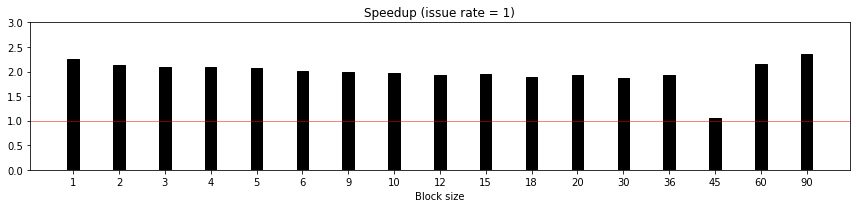

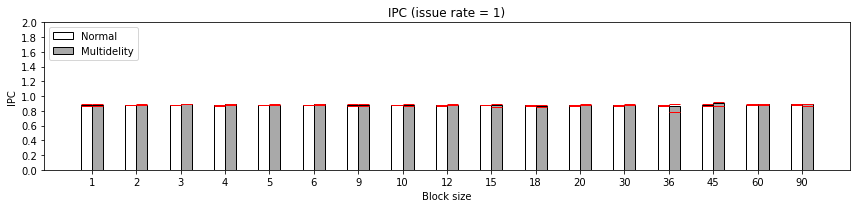

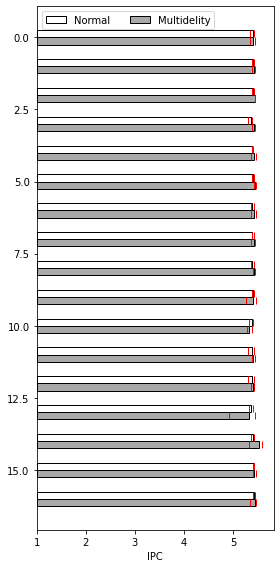

In [380]:
############### Matmul experiments
norm_matmul = [get_pickle(experiment) for experiment in ['Jul-15-0','Jul-15-1','Jul-15-2','Jul-15-3','Jul-15-4']]
#norm_matmul = [get_pickle(experiment) for experiment in ['Jul-25-12']]
mf_matmul = [get_pickle(experiment) for experiment in ['Jul-15-10', 'Jul-15-11', 'Jul-16-0', 'Jul-16-1', 'Jul-16-2']]
#mf_matmul = [get_pickle(experiment) for experiment in ['Jul-25-13']]
speedup_plot(mf_matmul, norm_matmul, y_max=2, issue_rate=1, filename='plots/matmul-speedup.pdf', matmul=True)
normalized_plot(mf_matmul, norm_matmul, y_max=2, issue_rate=1, filename='plots/matmul-accuracy.pdf', matmul=True)
normalized_plot_horizontal(mf_matmul, norm_matmul, y_max=2, issue_rate=1, filename='plots/matmul-accuracy-horizontal.pdf', matmul=True, tableName='matmul')


Mean speedup: 1.3266259054580773
MAPE of mean ipc: 2.2802424489965896
MAPE of mean ipc: 2.2802424489965896
printing table...
vvvvvvvv

\begin{table}[H]
\centering
\begin{tabular}{lllrr}
\toprule
      Benchmark & IPC$_{\text{true}}$ &  IPC$_{\text{mf}}$  & Pct. Error & Speedup \\
\midrule
      sp-01 & $0.62\pm0.00$ & $0.61\pm0.00$ & 1.80 & 1.46 \\
      sp-02 & $0.62\pm0.00$ & $0.62\pm0.00$ & -0.42 & \color{red}1.00\color{black} \\
      sp-03 & $0.61\pm0.00$ & $0.60\pm0.00$ & 1.02 & 1.38 \\
      sp-04 & $0.61\pm0.00$ & $0.61\pm0.00$ & 0.74 & \color{red}0.99\color{black} \\
      sp-05 & $0.59\pm0.00$ & $0.53\pm0.00$ & 11.90 & 1.46 \\
      sp-06 & $0.60\pm0.00$ & $0.59\pm0.00$ & 2.21 & 1.51 \\
      sp-07 & $0.58\pm0.00$ & $0.58\pm0.00$ & -0.04 & 1.35 \\
      sp-08 & $0.58\pm0.00$ & $0.58\pm0.00$ & 1.49 & 1.46 \\
\midrule
      Mean & &  & 2.45 & 1.33 \\
\bottomrule
\end{tabular}
\caption{\todo{caption}}
\label{tab:spatter}
\end{table}

^^^^^^^
done.


/nethome/plavin3/sst/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator


[1.7692749519173059,
 0.42501471921714334,
 1.0067380628947058,
 0.7298342082111648,
 10.637857815015014,
 2.1642618619183427,
 0.039190027093905615,
 1.469767945705134]

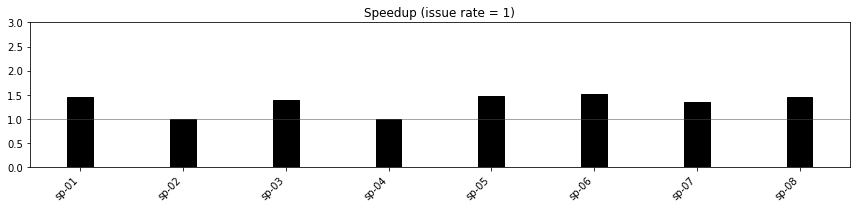

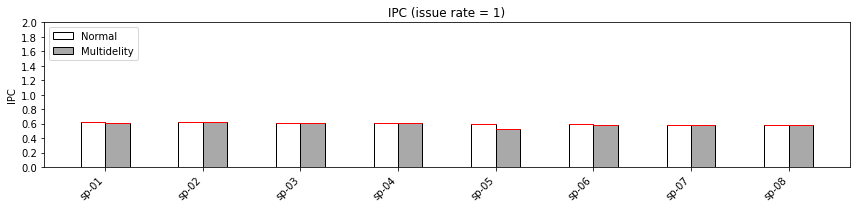

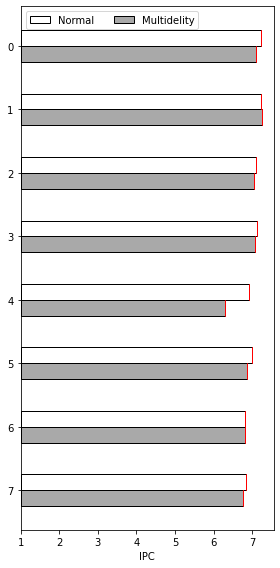

In [382]:
norm_spatter = [get_pickle(experiment) for experiment in ['Jul-17-22']]
mf_spatter = [get_pickle(experiment) for experiment in ['Jul-17-24']]
speedup_plot(mf_spatter, norm_spatter, y_max=2, issue_rate=1, filename=None)
normalized_plot(mf_spatter, norm_spatter, y_max=2, issue_rate=1, filename=None)
normalized_plot_horizontal(mf_spatter, norm_spatter, y_max=2, issue_rate=1, filename=None, matmul=True, tableName='spatter')


Mean speedup: 1.3266259054580773
MAPE of mean ipc: 2.2802424489965896


[1.7692749519173059,
 0.42501471921714334,
 1.0067380628947058,
 0.7298342082111648,
 10.637857815015014,
 2.1642618619183427,
 0.039190027093905615,
 1.469767945705134]

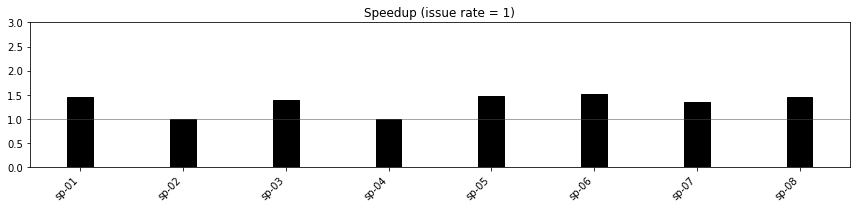

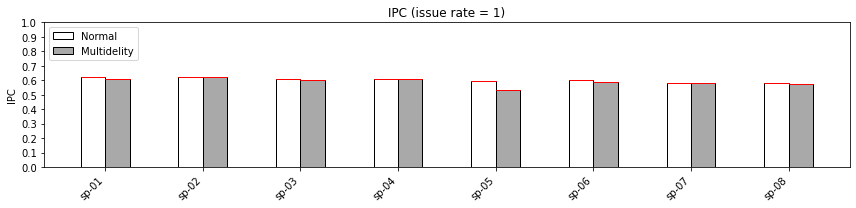

In [275]:
ns2 = [f'Jul-18-{n}' for n in range(5,15)]
#mfs2 = [*['Jul-18-{n}' for n in range(15,20)], *['Jul-19-{n}' for n in range(0,5)]]
mfs2 = ['Jul-19-4']
norm_spatter_2 = [get_pickle(experiment) for experiment in ns2]
mf_spatter_2 = [get_pickle(experiment) for experiment in mfs2]
speedup_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)
normalized_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)





Mean speedup: 1.3266259054580773
MAPE of mean ipc: 2.2802424489965896


[1.7692749519173059,
 0.42501471921714334,
 1.0067380628947058,
 0.7298342082111648,
 10.637857815015014,
 2.1642618619183427,
 0.039190027093905615,
 1.469767945705134]

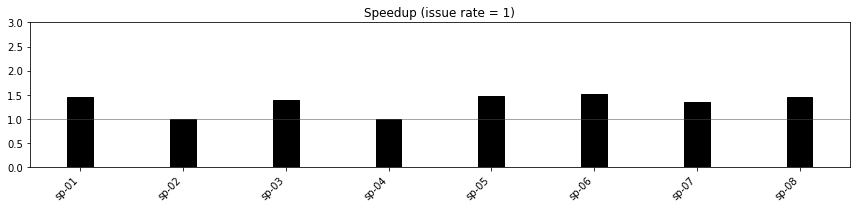

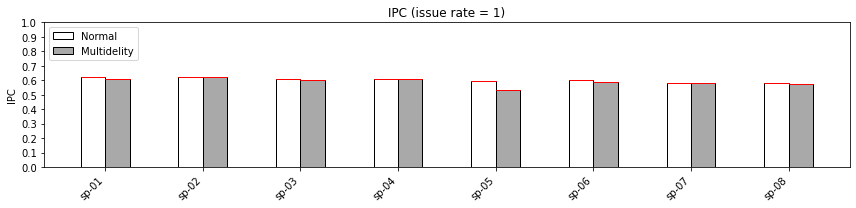

In [278]:
ns2 = [f'Jul-23-{n}' for n in range(3,8)]
mfs2 = [f'Jul-23-{n}' for n in range(8,13)]
norm_spatter_2 = [get_pickle(experiment) for experiment in ns2]
mf_spatter_2 = [get_pickle(experiment) for experiment in mfs2]
speedup_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)
normalized_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)

Mean speedup: 1.3266259054580773
MAPE of mean ipc: 2.2802424489965896


[1.7692749519173059,
 0.42501471921714334,
 1.0067380628947058,
 0.7298342082111648,
 10.637857815015014,
 2.1642618619183427,
 0.039190027093905615,
 1.469767945705134]

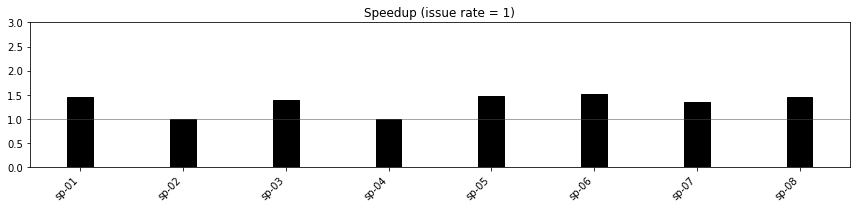

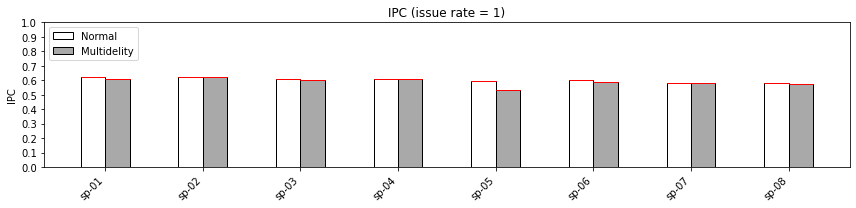

In [284]:
ns2 = [*[f'Jul-23-{n}' for n in range(13,17)], *['Jul-24-0']]
#mfs2 = [f'Jul-24-{n}' for n in range(1,6)]
mfs2 = ['Jul-24-5']
norm_spatter_2 = [get_pickle(experiment) for experiment in ns2]
mf_spatter_2 = [get_pickle(experiment) for experiment in mfs2]
speedup_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)
normalized_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)

Mean speedup: 1.3266259054580773
MAPE of mean ipc: 2.2802424489965896


[1.7692749519173059,
 0.42501471921714334,
 1.0067380628947058,
 0.7298342082111648,
 10.637857815015014,
 2.1642618619183427,
 0.039190027093905615,
 1.469767945705134]

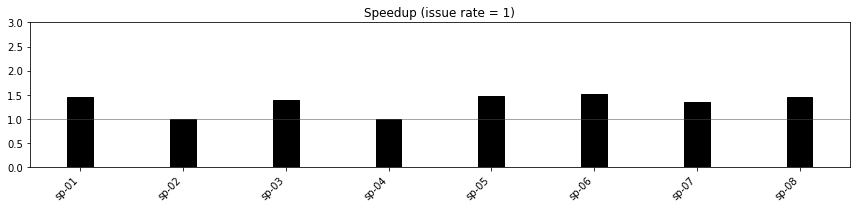

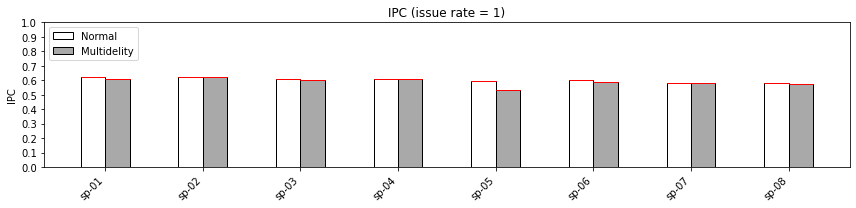

In [285]:
ns2 = ['Jul-24-6', 'Jul-25-0', 'Jul-25-1', 'Jul-25-2', 'Jul-25-3']
mfs2 = ['Jul-24-4', 'Jul-24-5', 'Jul-24-6', 'Jul-24-7', 'Jul-24-8']
norm_spatter_2 = [get_pickle(experiment) for experiment in ns2]
mf_spatter_2 = [get_pickle(experiment) for experiment in mfs2]
speedup_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)
normalized_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)

Mean speedup: 1.3266259054580773
MAPE of mean ipc: 2.2802424489965896


[1.7692749519173059,
 0.42501471921714334,
 1.0067380628947058,
 0.7298342082111648,
 10.637857815015014,
 2.1642618619183427,
 0.039190027093905615,
 1.469767945705134]

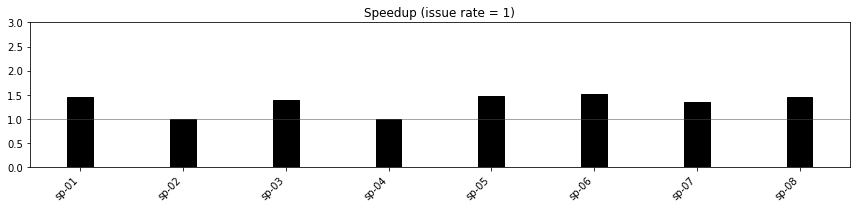

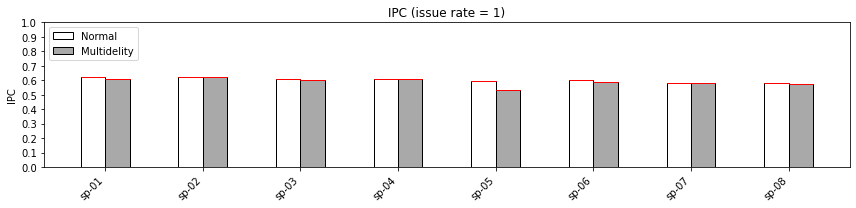

In [286]:
ns2 = ['Jul-25-9']
mfs2 = ['Jul-25-11']
norm_spatter_2 = [get_pickle(experiment) for experiment in ns2]
mf_spatter_2 = [get_pickle(experiment) for experiment in mfs2]
speedup_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)
normalized_plot(mf_spatter, norm_spatter, y_max=1, issue_rate=1, filename=None)